In [1]:
# Install itk for DICOM I/O and for reading DICOM into an itkImage
#   that manages all DICOM field values, include acquistion details
#   such as voxel image, image orientation, and image directions,
#   which are critical to image processing and display.

# Upgrade pip, just in case.
!python -m pip install --upgrade -q pip

# installations required for monai
!python -c "import monai" || pip install -q "monai[nibabel,itk,tqdm,pandas,skimage]"

# These are the libraries used to read DICOM Seg objects.
!python -m pip install -q pydicom pydicom-seg

# Install tcia_utils to download the datasets.
!python -m pip install --upgrade -q tcia_utils

# This is the installation required for itkWidgets.
!python -m pip install --upgrade --pre -q "itkwidgets[all]==1.0a20" imjoy_elfinder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00


In [2]:
import glob
import os

# Numpy for numpy.arrays
import numpy as np

# Include ITK for DICOM reading.
import itk

# Include pydicom_seg for DICOM SEG objects
import pydicom
import pydicom_seg

# for downloading data from TCIA
from tcia_utils import nbia

# This is the most common import command for itkWidgets.
#   The view() function opens an interactive viewer for 2D and 3D
#   data in a variety of formats.
from itkwidgets import view

# imports for monai
import torch
from monai.data import decollate_batch
from monai.bundle import ConfigParser, download

from monai.config import print_config

print_config()

MONAI version: 1.2.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.12.3
gdown version: 4.6.6
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.0rc0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recom

In [3]:
# If running on SageMaker or Studio Lab, install essential packages and extensions.
if "studio-lab-user" in os.getcwd():
    print("Upgrading dependencies")
    !conda install --yes -q --prefix {sys.prefix} -c conda-forge opencv nodejs

In [4]:
# Download a "Shared Cart" containing 6 scans from PROSTATEx
#    that has been previously created via the TCIA website
#    (https://nbia.cancerimagingarchive.net).
cart_name = "nbia-17571668146714049"

# retrieve cart metadata
cart_data = nbia.getSharedCart(cart_name)

# download the series_uids list and return dataframe of metadata
df = nbia.downloadSeries(cart_data, format="df")

# display dataframe
# display(df)

In [5]:
dicom_data_dir = "tciaDownload"

# The series_uid defines their directory where the MR data was stored on disk.
mr_series_uid = df.at[df.Modality.eq("MR").idxmax(), "Series UID"]
mr_dir = os.path.join(dicom_data_dir, mr_series_uid)

# Read the DICOM MR series' objects and reconstruct them into a 3D ITK image.
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI).
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html.
mr_image = itk.imread(mr_dir, itk.F)

In [6]:
# The series_uid defines where the RTSTRUCT was stored on disk.  It is stored in a single file.
seg_series_uid = df.at[df.Modality.eq("SEG").idxmax(), "Series UID"]
seg_dir = os.path.join(dicom_data_dir, seg_series_uid)
seg_file = glob.glob(os.path.join(seg_dir, "*.dcm"))[0]

# Read the DICOM SEG object using pydicom and pydicom_seg.
seg_dicom = pydicom.dcmread(seg_file)
seg_reader = pydicom_seg.MultiClassReader()
seg_obj = seg_reader.read(seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
seg_image = itk.GetImageFromArray(seg_obj.data.astype(np.float32))
seg_image.CopyInformation(mr_image)

In [7]:
model_name = "prostate_mri_anatomy"
model_version = "0.3.1"
zoo_dir = os.path.abspath("./models")

download(name=model_name, version=model_version, bundle_dir=zoo_dir)

2023-08-21 16:31:36,820 - INFO - --- input summary of monai.bundle.scripts.download ---
2023-08-21 16:31:36,822 - INFO - > name: 'prostate_mri_anatomy'
2023-08-21 16:31:36,824 - INFO - > version: '0.3.1'
2023-08-21 16:31:36,830 - INFO - > bundle_dir: '/content/models'
2023-08-21 16:31:36,833 - INFO - > source: 'github'
2023-08-21 16:31:36,835 - INFO - > remove_prefix: 'monai_'
2023-08-21 16:31:36,836 - INFO - > progress: True
2023-08-21 16:31:36,842 - INFO - ---




prostate_mri_anatomy_v0.3.1.zip: 269MB [00:02, 97.9MB/s]                          

2023-08-21 16:31:39,745 - INFO - Downloaded: /content/models/prostate_mri_anatomy_v0.3.1.zip
2023-08-21 16:31:39,747 - INFO - Expected md5 is None, skip md5 check for file /content/models/prostate_mri_anatomy_v0.3.1.zip.
2023-08-21 16:31:39,751 - INFO - Writing into directory: /content/models.


In [8]:
# This model includes scripts that must be run on new data.
#    We could import those scripts into this python notebook, but they
#    bring in additional dependencies.   Instead, we provide the following
#    more compact and compatible implementation.  Otherwise, you can
#    include the model's script directory by uncommenting these lines and
#    installing their dependencies and doing appropriate data conversions.
# scripts_dir = os.path.join(zoo_dir, model_name, "scripts")
# sys.path.insert(1, scripts_dir)


# Compact alternative implementation of this model's specific cropping step.
#   Ideally this would have been accomplished using MONAI's transforms
#   for data pre-processing / augmentation instead of using a separate
#   function.
def prostate_crop(img):
    boundary = [int(crop_size * 0.2) for crop_size in img.GetLargestPossibleRegion().GetSize()]
    new_image = itk.CropImageFilter(Input=img, BoundaryCropSize=boundary)
    return new_image


mr_image_prep = prostate_crop(mr_image)
seg_image_prep = prostate_crop(seg_image)

# Running a MONAI model on new data requires that data to be saved on
#   local disk.
itk.imwrite(mr_image_prep, mr_dir + ".nii.gz")
itk.imwrite(seg_image_prep, seg_dir + ".nii.gz")

In [9]:
# The model's config file dynamically generates the functions needed to process new data.

# Define our local system and filesystem.
output_dir = os.path.abspath("./monai_results")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parse the variables in the config file.
model_config_file = os.path.join(zoo_dir, model_name, "configs", "inference.json")
model_config = ConfigParser()
model_config.read_config(model_config_file)

# Update the confir variables to match our filesystem.
model_config["bundle_root"] = zoo_dir
model_config["output_dir"] = output_dir

# Identify which version of the model we want to load (each version is a
#    "checkpoint").  For most models, the "best" checkpoint is called "model.pt"
#    and it is stored in the models subdir.
checkpoint = os.path.join(zoo_dir, model_name, "models", "model.pt")

# Ask the config file to generate the functions needed to process new data.
#    These functions are adapted to our system by the config variables we
#    modified above.  The order of first defining variables and then creating the
#    functions is critical.
preprocessing = model_config.get_parsed_content("preprocessing")

model = model_config.get_parsed_content("network").to(device)

inferer = model_config.get_parsed_content("inferer")

postprocessing = model_config.get_parsed_content("postprocessing")

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [10]:
# Point the dataloader to the downloaded and converted TCIA data.
datalist = [mr_dir + ".nii.gz"]
model_config["datalist"] = datalist
dataloader = model_config.get_parsed_content("dataloader")

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



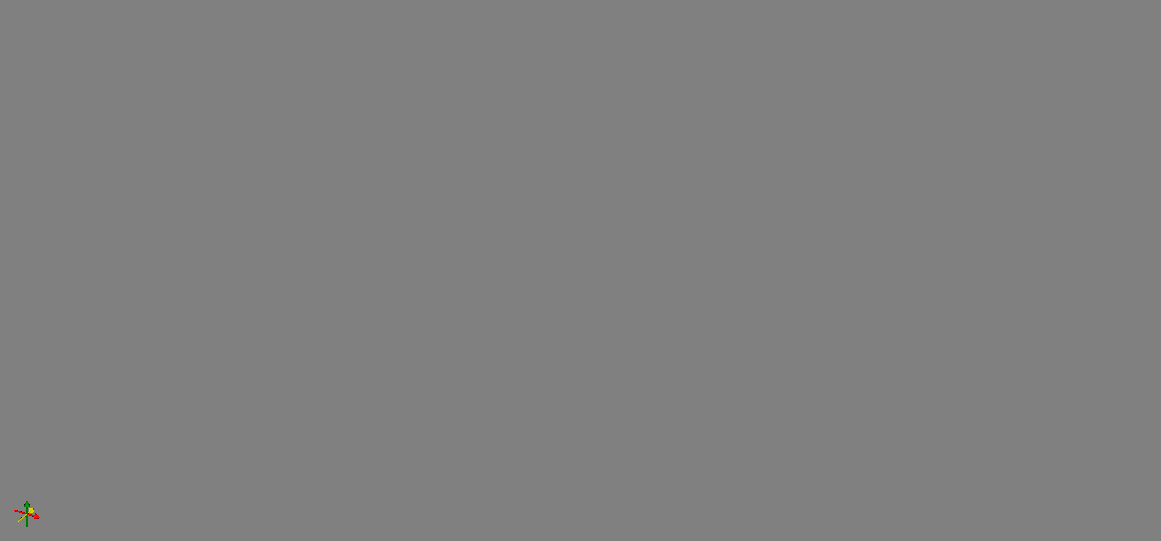
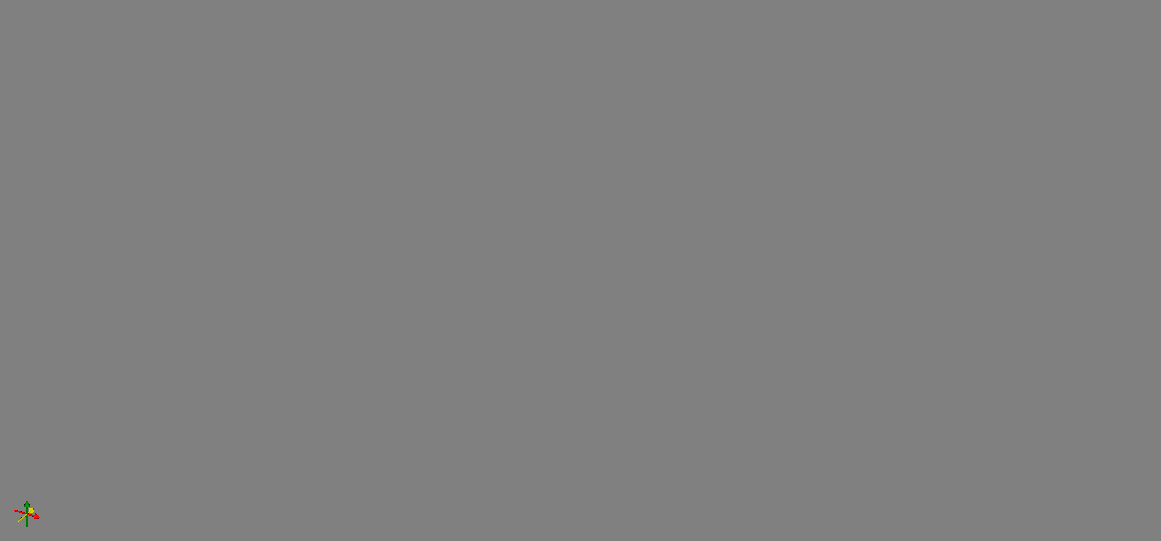

In [20]:

view(image=mr_image_prep, label_image=seg_image_prep)

In [12]:
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()
results = []
with torch.no_grad():
    for d in dataloader:
        images = d["image"].to(device)
        d["pred"] = inferer(images, network=model)
        results.append([postprocessing(i) for i in decollate_batch(d)])

2023-08-21 16:32:05,453 INFO image_writer.py:197 - writing: /content/monai_results/1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270520544417996275680/1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270520544417996275680_trans.nii.gz


In [13]:

# Read the result image that was written into the output_dir.
result_image = itk.imread(
    os.path.join(output_dir, os.path.split(mr_dir)[1], os.path.split(mr_dir)[1] + "_trans.nii.gz")
)

In [14]:
# Various manipulations were done to the input image before it is fed to the model
#    for inference.   As a result, the result image may not be in the same
#    spacing, orientation, etc as the original input data.  So, we resample the results
#    image to match the physical properties of the original input data.
interpolator = itk.NearestNeighborInterpolateImageFunction.New(seg_image)
result_image_resampled = itk.resample_image_filter(
    Input=result_image, Interpolator=interpolator, reference_image=seg_image_prep, use_reference_image=True
)


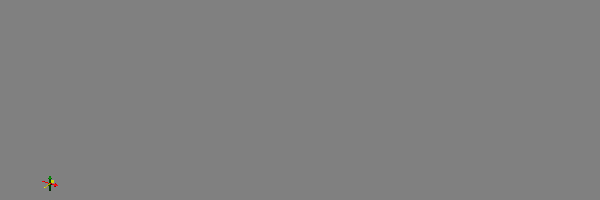
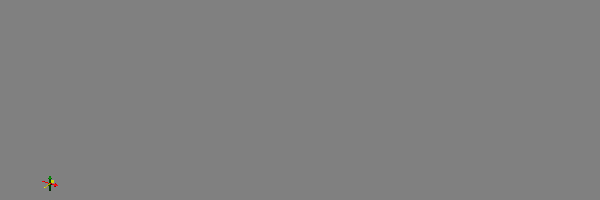

In [15]:
# View the image with results overlaid in an interactive 2D slice viewer.
viewer_b = view(image=mr_image_prep, label_image=result_image_resampled)


In [16]:
viewer_b.set_image_color_map("Grayscale")
viewer_b.set_label_image_blend(0.5)
viewer_b.set_image_color_range([100, 500])
viewer_b.set_view_mode("ZPlane")
viewer_b.set_ui_collapsed(False)


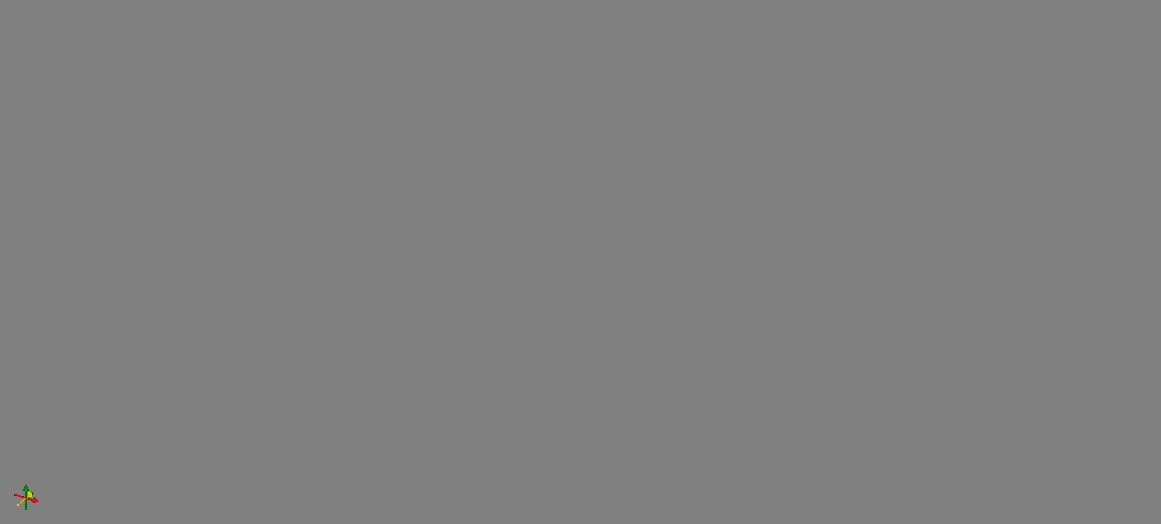
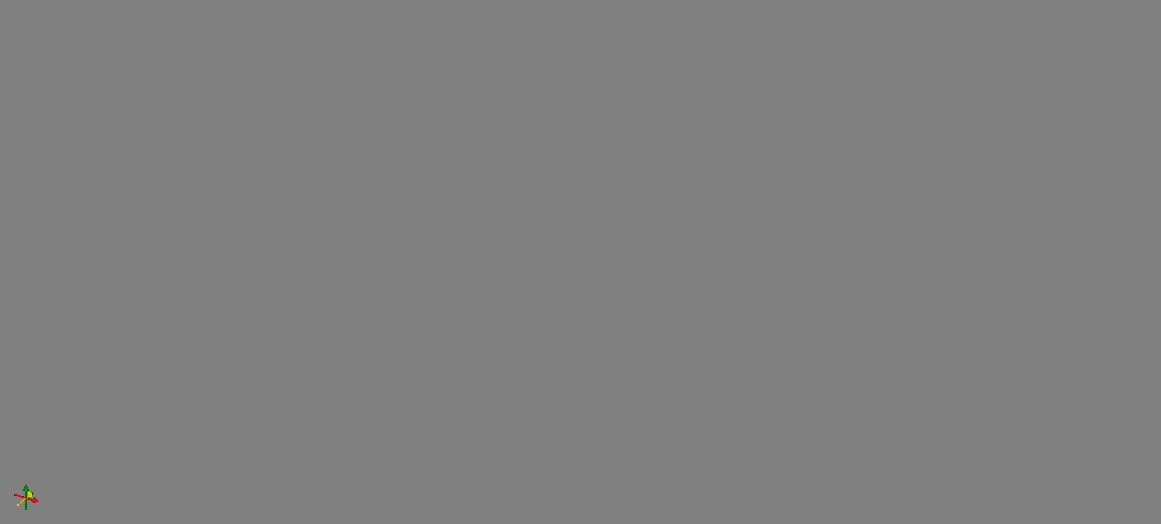

In [19]:
result_array = itk.GetArrayViewFromImage(result_image_resampled)
expert_array = itk.GetArrayViewFromImage(seg_image_prep)

# Note that the data in the ProstateX repo uses different labels than the data used to
#    build the model.  For example, the prostate is label 1 in the model and label 2
#    in the ProstateX data.
# The following creates a label image where
#    1 = ideal prostate, but model called non-prostate (red)
#    2 = model called prostate, but ideal called non-prostate (purple)
#    3 = modeal and ideal agreed (green)
compare_model_expert = np.where(result_array != 1, 0, 2) + np.where(expert_array != 2, 0, 1)
compare_image = itk.GetImageFromArray(compare_model_expert.astype(np.float32))
compare_image.CopyInformation(seg_image_prep)

viewer_c = view(image=mr_image_prep, label_image=compare_image)

In [21]:
# Switch to an interactive slice view so that labels are more easily seen.
viewer_c.set_label_image_blend(0.6)
viewer_c.set_image_color_map("Grayscale")
viewer_c.set_view_mode("ZPlane")
viewer_c.set_image_color_range([100, 500])
viewer_c.set_ui_collapsed(False)